In [87]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
warnings.filterwarnings('ignore')

df = pd.read_csv("shuttle-unsupervised-ad.csv", names=["a",'b','c','d', 'e', 'f' , 'g', 'h', 'i', 'j'])
#df.cols = ["ä",'b','c','d', 'e', 'f' , 'g', 'h', 'i']

df.head()

,a,b,c,d,e,f,g,h,i,j
0,108.0,3.0,109.0,0.0,72.0,7.0,1.0,36.0,36.0,o
1,81.0,0.0,84.0,0.0,-14.0,-2.0,4.0,100.0,96.0,o
2,81.0,0.0,84.0,0.0,-20.0,16.0,4.0,105.0,102.0,o
3,76.0,-1.0,81.0,0.0,-42.0,-3.0,5.0,125.0,120.0,o
4,105.0,0.0,107.0,2.0,70.0,0.0,1.0,37.0,36.0,o


In [88]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,a,b,c,d,e,f,g,h,i,j
0,38.0,4.0,77.0,0.0,38.0,14.0,39.0,38.0,0.0,n
1,37.0,0.0,81.0,-3.0,-2.0,0.0,44.0,83.0,40.0,n
2,53.0,-1.0,86.0,0.0,52.0,-20.0,33.0,34.0,2.0,n
3,43.0,-1.0,88.0,0.0,44.0,21.0,44.0,44.0,0.0,n
4,51.0,1.0,83.0,0.0,50.0,-19.0,31.0,33.0,2.0,n


In [36]:
df.j.unique()

array(['n', 'o'], dtype=object)

In [37]:
df.replace('o', 0, inplace=True)
df.replace('n', 1, inplace= True)
df.head()

,a,b,c,d,e,f,g,h,i,j
0,41.0,0.0,79.0,-7.0,38.0,-1.0,39.0,41.0,2.0,1
1,45.0,0.0,86.0,1.0,44.0,0.0,40.0,42.0,2.0,1
2,36.0,0.0,83.0,0.0,36.0,6.0,47.0,47.0,0.0,1
3,37.0,-1.0,79.0,0.0,34.0,0.0,42.0,45.0,2.0,1
4,37.0,0.0,76.0,0.0,30.0,-24.0,39.0,45.0,6.0,1


In [38]:
df.tail()


,a,b,c,d,e,f,g,h,i,j
46459,43.0,0.0,81.0,6.0,42.0,-2.0,37.0,39.0,2.0,1
46460,43.0,1.0,86.0,-2.0,42.0,0.0,43.0,45.0,2.0,1
46461,40.0,3.0,102.0,0.0,38.0,0.0,61.0,63.0,2.0,1
46462,56.0,3.0,86.0,0.0,56.0,9.0,31.0,30.0,0.0,1
46463,37.0,0.0,95.0,0.0,12.0,-14.0,58.0,82.0,24.0,1


In [39]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df= pd.DataFrame(x_scaled)

In [40]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.145833,0.695092,0.453125,0.506114,0.362179,0.457870,0.496183,0.632424,0.575563,1.0
1,0.187500,0.695092,0.507812,0.507144,0.371795,0.457906,0.503817,0.634029,0.575563,1.0
2,0.093750,0.695092,0.484375,0.507015,0.358974,0.458120,0.557252,0.642055,0.572347,1.0
3,0.104167,0.694936,0.453125,0.507015,0.355769,0.457906,0.519084,0.638844,0.575563,1.0
4,0.104167,0.695092,0.429688,0.507015,0.349359,0.457048,0.496183,0.638844,0.581994,1.0


In [41]:
df.rename(columns={ df.columns[9]: 'a'}, inplace = True)
df.head()

,0,1,2,3,4,5,6,7,8,a
0,0.145833,0.695092,0.453125,0.506114,0.362179,0.457870,0.496183,0.632424,0.575563,1.0
1,0.187500,0.695092,0.507812,0.507144,0.371795,0.457906,0.503817,0.634029,0.575563,1.0
2,0.093750,0.695092,0.484375,0.507015,0.358974,0.458120,0.557252,0.642055,0.572347,1.0
3,0.104167,0.694936,0.453125,0.507015,0.355769,0.457906,0.519084,0.638844,0.575563,1.0
4,0.104167,0.695092,0.429688,0.507015,0.349359,0.457048,0.496183,0.638844,0.581994,1.0


In [42]:
RANDOM_SEED = 314
TEST_PCT = 0.2

rcParams['figure.figsize'] = 14, 8.7 
LABELS = ["o","n"]
#col_list = ["cerulean","scarlet"]
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))
df.shape

(46464, 10)

In [43]:
df.isnull().values.any()

False

In [44]:
pd.value_counts(df['a'], sort = True)

1.0    45586
0.0      878
Name: a, dtype: int64

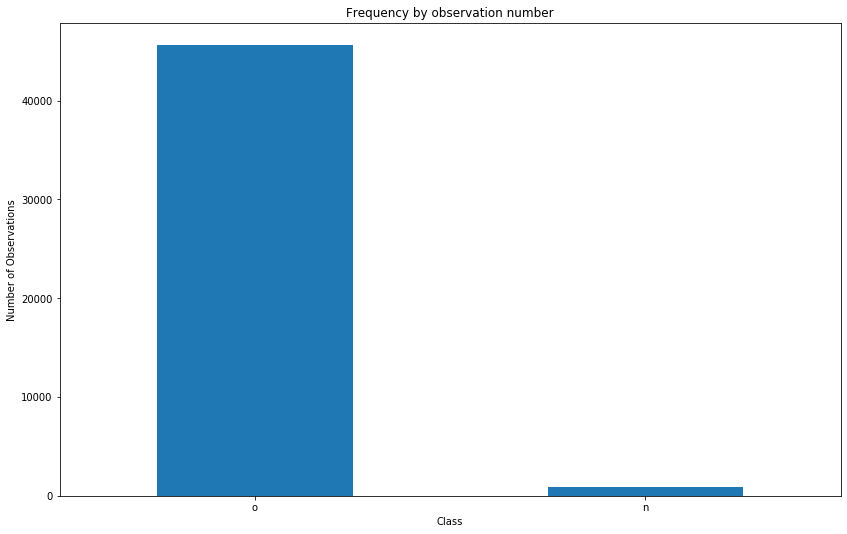

In [45]:
count_classes = pd.value_counts(df['a'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [46]:
normal_df = df[df.a == 0] 
anamolous_df = df[df.a == 1]
y=df['a']
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(37171, 10) (37171,)
(9293, 10) (9293,)


In [47]:
X_train.shape

(37171, 10)

In [48]:
nb_epoch = 20
batch_size = 128
input_dim = X_train.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim = int(encoding_dim / 2) #i.e. 7
learning_rate = 1e-7

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_edge.h5",save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir=r'C:\Users\Shubham\work\logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 37171 samples, validate on 9293 samples
Epoch 1/20
37171/37171 [==============================] - 1s 14us/step - loss: 0.1380 - accuracy: 0.7308 - val_loss: 0.1165 - val_accuracy: 0.9905
Epoch 2/20
37171/37171 [==============================] - 0s 10us/step - loss: 0.0939 - accuracy: 0.9835 - val_loss: 0.0691 - val_accuracy: 0.9811
Epoch 3/20
37171/37171 [==============================] - 0s 8us/step - loss: 0.0689 - accuracy: 0.9818 - val_loss: 0.0689 - val_accuracy: 0.9812
Epoch 4/20
37171/37171 [==============================] - 0s 10us/step - loss: 0.0688 - accuracy: 0.9819 - val_loss: 0.0687 - val_accuracy: 0.9825
Epoch 5/20
37171/37171 [==============================] - 0s 10us/step - loss: 0.0687 - accuracy: 0.9860 - val_loss: 0.0686 - val_accuracy: 0.9891
Epoch 6/20
37171/37171 [==============================] - 0s 10us/step - loss: 0.0686 - accuracy: 0.9891 - val_loss: 0.0685 - val_accuracy: 0.9915
Epoch 7/20
37171/37171 [==============================] - 0s 10us/step

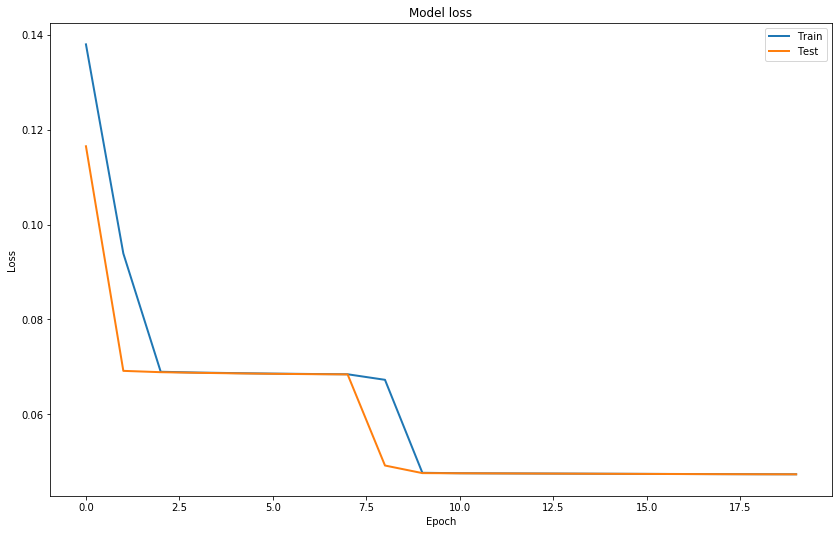

In [49]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()